In [21]:
import os, sys, re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# установка стиля matplotlib
%matplotlib inline
# plt.style.use('ggplot')

# доступные стили отображения графика в matplotlib
# plt.style.available

# библиотека для расчетов метрик
# from scipy import stats
from sklearn import metrics

# библиотека для нормализации, стандартизации
# from sklearn import preprocessing

# библиотека модели кластеризации
# from sklearn import cluster

# библиотека для разделения датасета
from sklearn import model_selection

# библиотека для исключения признаков RFE
# from sklearn import feature_selection

# библиотека для кодирования признаков
# import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# работа с json
# import json
from pprint import pprint

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# логгирование / логирование
import logging

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# библиотека для передачи функции обратного вызова
# from functools import partial

# библиотека поиска гиперпараметров hyperopt
# import hyperopt
# from hyperopt import hp, fmin, tpe, Trials

# библиотека поиска гиперпараметров optuna
import optuna
from optuna import Trial, study, samplers

# библиотека байесовских алгоритмов
from sklearn import naive_bayes

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.large_repr', 'truncate')
# pd.set_option('display.max_columns', 40)

In [22]:
# КОНСТАНТЫ
SRC_SUBFOLDER = './.'

# формируем относительный системный путь для импорта файлов с функциями
# если SRC_SUBFOLDER = './.' + './', получим относительный путь './../'
sys.path.append(os.path.relpath(SRC_SUBFOLDER + './'))

# импортируем константы
from src.constants import *

# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [23]:
# считываем данные
data = pd.read_csv(DATA_SUBFOLDER + './data/spam_or_not_spam.csv')
data['label'] = data['label'].astype('int8')

# выводим результат
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int8  
dtypes: int8(1), object(1)
memory usage: 26.5+ KB


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [24]:
# смотрим распределение классов
data['label'].value_counts()

# смотрим процентное распределение классов
round(data['label'].value_counts(normalize=True) * 100, 2)

label
0    2500
1     500
Name: count, dtype: int64

label
0    83.33
1    16.67
Name: proportion, dtype: float64

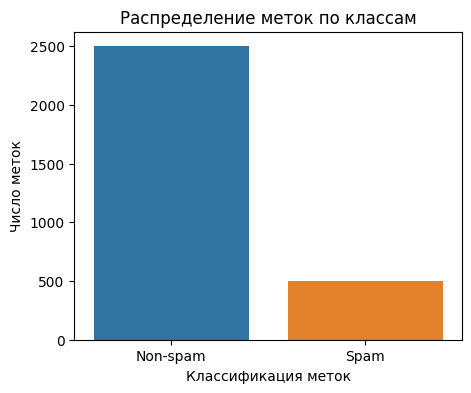

In [25]:
# задаём полотно
fig, ax_countplot = plt.subplots(figsize=(5, 4))

# строим график
sns.countplot(data=data, x='label')

# задаём заголовок, подписи осей и меток
ax_countplot.set(
    title='Распределение меток по классам',
    xlabel='Классификация меток', 
    ylabel='Число меток',
    xticklabels=['Non-spam', 'Spam']
);

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [26]:
from sklearn.feature_extraction import text

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [27]:
# делаем копию датасета
data_clean = data.copy()

# удаляем пропуски
data_clean['email'] = data_clean['email'].replace(r'^\s*$', np.nan, regex=True)
data_clean.dropna(how='any', inplace=True)

# выводим результат
data_clean.info()
data_clean.shape
data_clean.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2997 non-null   object
 1   label   2997 non-null   int8  
dtypes: int8(1), object(1)
memory usage: 49.8+ KB


(2997, 2)

email    0
label    0
dtype: int64

In [28]:
# переносим результат
data = data_clean

Переводим данные в векторный вид:

In [29]:
CV_vectorizer = text.CountVectorizer()
X = CV_vectorizer.fit_transform(data['email'])

Определите, сколько теперь признаков в нашем наборе данных:

In [30]:
print(f'После обработки создано {X.shape[1]} признаков')

После обработки создано 34116 признаков


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [31]:
# задаём целевой переменную
y = data['label']

# выводим результат
print(f'Размер обучающей выборки: {X.shape}')
print(f'Размер тестовой выборки: {y.shape}')

Размер обучающей выборки: (2997, 34116)
Размер тестовой выборки: (2997,)


Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.25, 
    stratify=y, 
    random_state=RANDOM_SEED_42
)

# выводим результат
print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер обучающей выборки: (2247, 34116)
Размер тестовой выборки: (750, 34116)


Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [33]:
print(f'Среднее значение целевой переменнной на тестовой выборке: {round(y_test.mean(), 3)}')

Среднее значение целевой переменнной на тестовой выборке: 0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

---

В библиотеке ***sklearn*** есть несколько байесовских классификаторов:

* **[GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)** — самый простой вариант, работает с непрерывными признаками;

* **[MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)**  — работает с категориальными признаками, текстами и несбалансированными выборками;

* **[ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html)** — улучшенная версия MultinomialNB, стабильно показывает более высокое качество в задачах классификации текстов;

* **[BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)** — версия для работы с бинарными признаками;

* **[CategoricalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)** — работает с категориальными признаками, предполагает кодировку данных через **OrdinalEncoder**.

Наиболее подходящие классификаторы - **MultinomialNB** & **ComplementNB**, поскольку ComplementNB улучшенная версия MultinomialNB, то его и будем применять.

In [34]:
# задаём объект класса ComplementNB
CNB = naive_bayes.ComplementNB(alpha=0.01)

# обучаем модель
CNB.fit(X_train, y_train)

# предсказываем значения на тестовой выборке
y_pred_cnb = CNB.predict(X_test)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [35]:
print(metrics.classification_report(y_test, y_pred_cnb, digits=TOL))

              precision    recall  f1-score   support

           0    0.98583   1.00000   0.99286       626
           1    1.00000   0.92742   0.96234       124

    accuracy                        0.98800       750
   macro avg    0.99291   0.96371   0.97760       750
weighted avg    0.98817   0.98800   0.98782       750



Нарисуйте ROC-кривую:

In [36]:
# вычисляем вероятности классов на тестовых выборках
# интересует только вероятность класса 1
y_pred_prob_cnb = CNB.predict_proba(X_test)[:, 1]

# вычисляем координаты точек ROC кривых
false_positive_rates_cnb, true_positive_rates_cnb, _ = metrics.roc_curve(y_test, y_pred_prob_cnb)

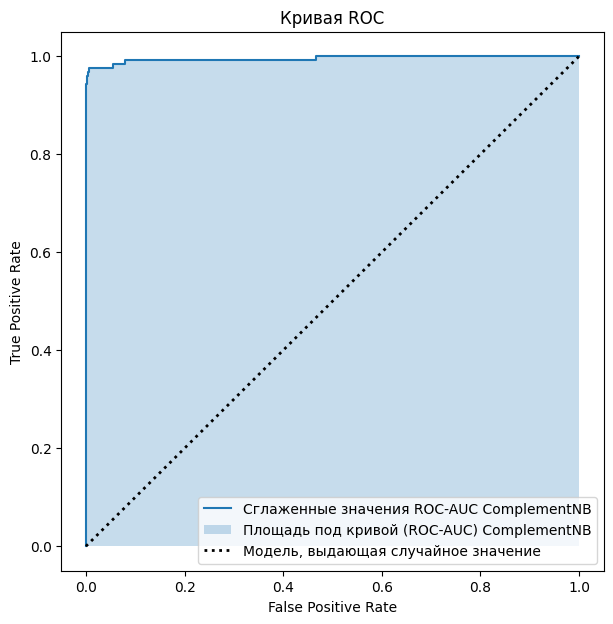

In [37]:
# создаём полотно
plt.figure(figsize=(7, 7))

# рисуем ROC кривую
plt.plot(false_positive_rates_cnb, true_positive_rates_cnb, 
    label=f'Сглаженные значения ROC-AUC {CNB.__class__.__name__}')

# выполняем заливку под кривой
plt.fill_between(false_positive_rates_cnb, true_positive_rates_cnb, step='pre', 
    alpha=TOL/20, label=f'Площадь под кривой (ROC-AUC) {CNB.__class__.__name__}'
)

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
    label='Модель, выдающая случайное значение'
)

# задаём заголовки и подписи осей
plt.title('Кривая ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show();

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [38]:
# задаём сетку параметра alpha с шагом 0.05
params_cnb = {'alpha': np.round(np.linspace(0, 10, num=201), TOL)}

# задаём объект класса GridSearchCV
GSCV_CNB = model_selection.GridSearchCV(
    estimator=naive_bayes.ComplementNB(), 
    param_grid=params_cnb, 
    scoring='f1', 
    n_jobs=CPU_ALL, 
    cv=TOL
)

# обучаем модель, ищем оптимальный гиперпараметр
GSCV_CNB.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,...
        6.3 ,  6.35,  6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,  6.65,  6.7 ,
        6.75,  6.8 ,  6.85,  6.9 ,  6.95,  7.  ,  7.05,  7.1 ,  7.15,
        7.2 ,  7.25,  7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,  7.55,  7.6 ,
        7.65,  7.7 ,  7.75,  7.8 ,  7.85,  7.9 ,  7.95,  8.  ,  8.05,
        8.1 ,  8.15,  8.2 ,  8.25,  8.3 ,  8.35,  8.4 ,  8.45,  8.5 ,
        8.55,  8.6 ,  8.65,  8.7 ,  8.75,  8.8 ,  8.85,  8.9 ,  8.95,
        9.  ,  9.05,  9.1 ,  9.15,  9.2 ,  9.25,  9.3 ,  9.35,  9.4 ,
        9.45,  9.5 ,  9.55,  9.6 ,  9.65,  9.7 ,  9.75,  9.8 ,  9.85,
        9.9 ,  9.95, 10.  ])},
             scoring='f1')

In [39]:
print(f'Метрика F1: {GSCV_CNB.best_score_:.{TOL}f}')
print(f'Лучший гиперпараметр: {GSCV_CNB.best_params_}')

Метрика F1: 0.97449
Лучший гиперпараметр: {'alpha': 0.35}


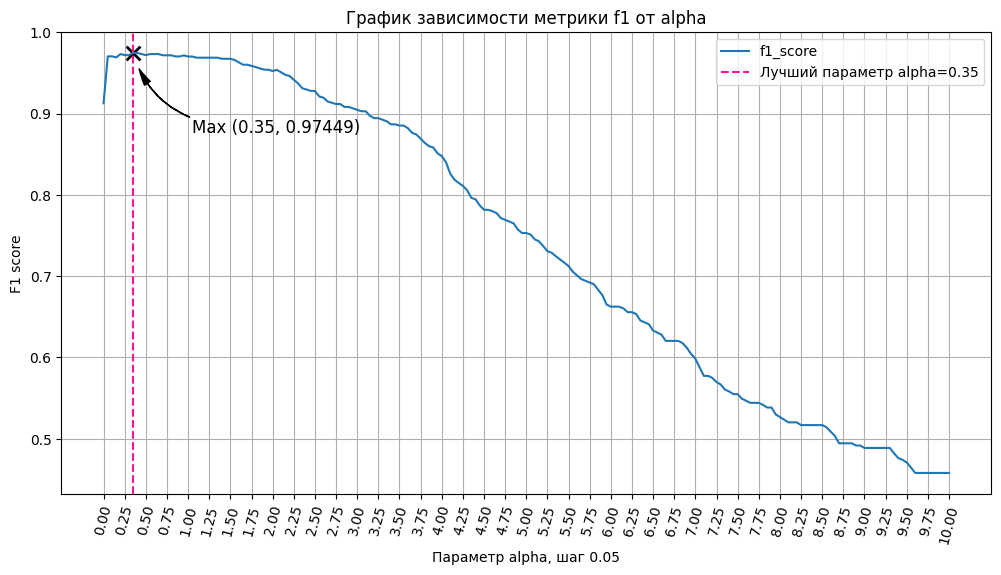

In [40]:
# отрисуем, как менялся f1_score при различном alpha
# создаём датафрейм для графика
visual_df = pd.DataFrame(
    GSCV_CNB.cv_results_['mean_test_score'], 
    index=GSCV_CNB.cv_results_['param_alpha'],
    columns=['f1_score']
)

# задаём полотно
fig, ax_line = plt.subplots(figsize=(12, 6))

# выделяем координаты
x_, y_ = visual_df.idxmax().values[0], round(visual_df.max()[0], TOL)

# строим графики
sns.lineplot(visual_df)
plt.axvline(visual_df.idxmax().values, c='deeppink',lw=1.5, ls='--', label=f'Лучший параметр alpha={x_}')

# аннотируем детали графика
plt.scatter(x=x_, y=y_, c='black', lw=2, marker='x', s=100)
plt.annotate(
    f'Max ({x_}, {y_})',
    xy=(x_*1.2, y_*.98),
    xytext=(x_*3, y_*.9),
    arrowprops = dict(
        facecolor='black', 
        width=0.2, 
        headwidth=5,
        connectionstyle="arc3, rad=-0.2"
    ),
    fontsize=12,
    horizontalalignment='left')

# задаём заголовок графика, подписи осей и метки по оси абсцисс
ax_line.set(
    title='График зависимости метрики f1 от alpha', 
    xlabel='Параметр alpha, шаг 0.05', 
    ylabel='F1 score', 
    # для оси меток берем минимум и максимум значений словаря params_cnb, 
    # а шаг задаётся размерностью params_cnb меньше в 5 раз
    xticks=np.linspace(
        np.array(list(params_cnb.values())).min(), 
        np.array(list(params_cnb.values())).max(), 
        int((np.array(list(params_cnb.values())).shape[1] - 1) / 5 + 1)
    ),
)

# выводим сетку и легенду
ax_line.legend()
ax_line.grid()

# поворачиваем метки
plt.xticks(rotation=75);

---

## Выводы:

* Качество классификации зависит от параметра сглаживания $\alpha$ усовершенствованого наивного байесовского алгоритма **ComplementNB** - с его увеличением наблюдается снижение метрики $F_1$, максимально рекомендуемое значение для параметра $\alpha$ : $\alpha \leq 1.0$, значение $\alpha = 1.0$ установлено оптимальным по умолчанию в **ComplementNB**. График наглядно отражает сильное падение, начиная со значения $\alpha \geq 1.75$;

* Значение  $\alpha = 0.01$, заданное изначально в расчётах, практически, сразу задаёт предельно высокий уровень метрик $Precision$, $Recall$, включая $F_1$;

* Подобранное лучшее значение параметра $\alpha = 0.35$ может ещё немного улучшить метрику $F_1$ после 2 знака и, соответственно - качество модели.